<a href="https://colab.research.google.com/github/SukhBhagsar/SukhBhagsar/blob/main/SparseAutoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
# loading necessary libraries
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from skimage import io


In [4]:
# loading dataset
import zipfile

with zipfile.ZipFile('/content/facedetectionDS.zip', 'r') as zip_ref:
    zip_ref.extractall('extracted_dataset/')

In [5]:
# loading images from directories
def load_images(folder):
    images = []
    for filename in os.listdir(folder):
        img = load_img(os.path.join(folder, filename), color_mode="grayscale", target_size=(64, 64))
        img_array = img_to_array(img)
        images.append(img_array)
    return np.array(images)

# Loading images from the given datset
faces_data = '/content/extracted_dataset/facedetectionDS/faces'
non_faces_data = '/content/extracted_dataset/facedetectionDS/notfaces'

# Loading and preprocessing images
faces_data = load_images(faces_data)
non_faces_data = load_images(non_faces_data)

# Combining face and non-face data
X = np.concatenate((faces_data, non_faces_data), axis=0)

# Normalizing  pixel values  between 0 and 1
X = X.astype('float32') / 255.

# Flattening image data  into vectors
X = X.reshape((len(X), np.prod(X.shape[1:])))

# Creating labels for faces (1) and non-faces (0)
y_faces = np.ones(len(faces_data))
y_non_faces = np.zeros(len(non_faces_data))

# Combining label
y = np.concatenate((y_faces, y_non_faces), axis=0)

# Spliting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


print("Training set dimensions:", X_train.shape)
print("Testing set dimensions:", X_test.shape)
print("Training labels dimensions:", y_train.shape)
print("Testing labels dimensions:", y_test.shape)


Training set dimensions: (5630, 4096)
Testing set dimensions: (1408, 4096)
Training labels dimensions: (5630,)
Testing labels dimensions: (1408,)


In [10]:
# Creating Sparse Autoencoder Model
def sparse_autoencoder(input_shape, encoding_dim, sparsity_regularizer):
    input_image = Input(shape=input_shape)
    encoded = Dense(encoding_dim, activation='relu',
                    activity_regularizer=regularizers.l1(sparsity_regularizer))(input_image)
    decoded = Dense(input_shape[0], activation='sigmoid')(encoded)
    autoencoder = Model(input_image, decoded)
    return autoencoder
input_shape = (4096,)
encoding_dim = 32
sparsity_regularizer = 0.01

autoencoder = sparse_autoencoder(input_shape, encoding_dim, sparsity_regularizer)
# Model summary
autoencoder.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 4096)]            0         
                                                                 
 dense_4 (Dense)             (None, 32)                131104    
                                                                 
 dense_5 (Dense)             (None, 4096)              135168    
                                                                 
Total params: 266272 (1.02 MB)
Trainable params: 266272 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
# Performing preprocessing images from directories
def image_preprocessing(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        image = io.imread(os.path.join(folder, filename))
        image = preprocess_image(image)
        images.append(image)
        labels.append(label)
    return images, labels

def preprocess_image(image):
    # Example: Resize image to (64, 64) and normalize pixel values
    image = resize_image(image, target_size=(64, 64))
    image = image / 255.0  # Normalize pixel values
    return image

# Resizing image
def resize_image(image, target_size):
    # Example: using scikit-image resize function
    from skimage.transform import resize
    return resize(image, target_size)

faces_folder = '/content/extracted_dataset/facedetectionDS/faces'
non_faces_folder = '/content/extracted_dataset/facedetectionDS/notfaces'

# preprocessing images from both folders
faces_images, faces_labels = image_preprocessing(faces_folder, label=1)
non_faces_images, non_faces_labels = image_preprocessing(non_faces_folder, label=0)

# Combine images and labels from both folders
X = np.concatenate((faces_images, non_faces_images), axis=0)
y = np.concatenate((faces_labels, non_faces_labels), axis=0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print shapes of training and testing sets
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


Training set shape: (5630, 64, 64, 3)
Testing set shape: (1408, 64, 64, 3)


In [19]:
# Creating Sparse Autoencoder model
def sparse_autoencoder(input_shape, encoding_dim):
    input_img = Input(shape=input_shape)
    encoded = Dense(encoding_dim, activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-5))(input_img)
    decoded = Dense(3, activation='sigmoid')(encoded)
    autoencoder = Model(input_img, decoded)
    return autoencoder

#  input shape and encoding dimension
input_shape = (64, 64, 3)
encoding_dim = 32

# Creating Sparse Autoencoder model
autoencoder = sparse_autoencoder(input_shape, encoding_dim)

# Compiling model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Model summary
autoencoder.summary()

# Training model
autoencoder.fit(X_train, X_train,
                epochs=5,
                batch_size=128,
                shuffle=True,
                validation_data=(X_test, X_test))

# Model Evaluation
loss = autoencoder.evaluate(X_test, X_test)
print("Test Loss:", loss)


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 dense_6 (Dense)             (None, 64, 64, 32)        128       
                                                                 
 dense_7 (Dense)             (None, 64, 64, 3)         99        
                                                                 
Total params: 227 (908.00 Byte)
Trainable params: 227 (908.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
44/44 [==============================] - 21s 450ms/step - loss: 0.6826 - val_loss: 0.6715
Epoch 2/5
44/44 [==============================] - 19s 437ms/step - loss: 0.6612 - val_loss: 0.6505
Epoch 3/5
44/44 [==============================] - 24s 554ms/step - loss: 0.6406 - va

In [22]:
# Extracting encoder and decoder from the autoencoder model
encoder_model = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('dense_6').output)
decoder_model = Model(inputs=autoencoder.get_layer('dense_7').input, outputs=autoencoder.output)

# Encoding images
encoded_images = encoder_model.predict(X_test)

# Decoding encoded images to generate reconstructed images
reconstructed_images = decoder_model.predict(encoded_images)


44/44 [==============================] - 1s 11ms/step


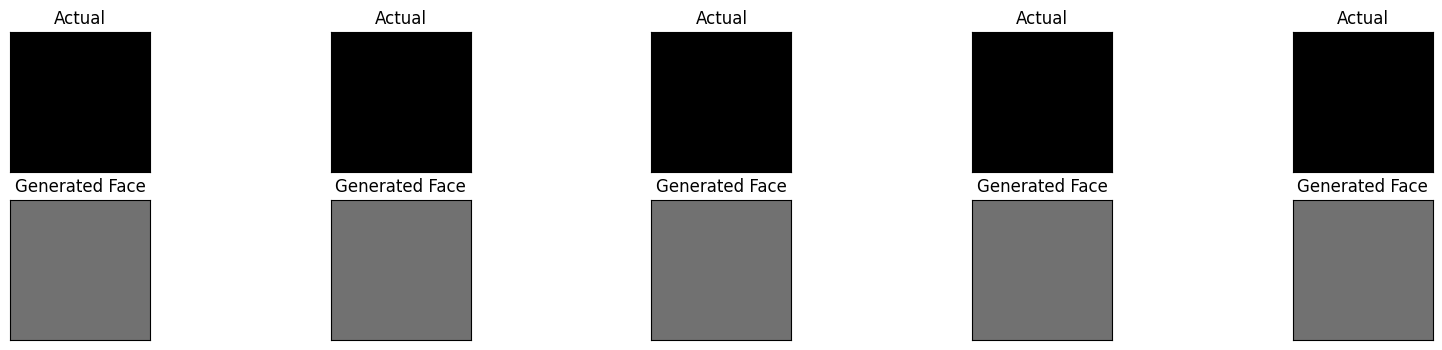

In [24]:
import matplotlib.pyplot as plt

image_no = 5
plt.figure(figsize=(20, 4))
for i in range(image_no):
    # Displaying Actual images
    ax = plt.subplot(2, image_no, i + 1)
    plt.imshow(X_test[i].reshape(64, 64, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title("Actual")

    # Displaying reconstructed images or generated faces
    ax = plt.subplot(2, image_no, i + 1 + image_no)
    plt.imshow(reconstructed_images[i].reshape(64, 64, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title("Generated Face")
plt.show()


In [25]:
from sklearn.metrics import mean_squared_error

# Reshaping original and reconstructed images for compatibility with MSE
X_test_reshaped = X_test.reshape(-1, 64*64*3)
reconstructed_images_reshaped = reconstructed_images.reshape(-1, 64*64*3)

# Calculating MSE
mse_loss = mean_squared_error(X_test_reshaped, reconstructed_images_reshaped)
print("Mean Squared Error Loss:", mse_loss)


Mean Squared Error Loss: 0.1982024439756739
